<a href="https://colab.research.google.com/github/saurabhbarge/CE888-7-SP/blob/main/TweetEval_Assignment2/Offensive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing all the Libraries**

In [76]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
import re
import string
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt 
%matplotlib inline
import seaborn as sns

In [77]:
!pip install fasttext
import fasttext

In [78]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [79]:
stop_words = list(set(stopwords.words('english'))) # list of stop words

In [80]:
stemmer = PorterStemmer() # creating stemmer object

In [81]:
lemmatizer = WordNetLemmatizer() # creating lemmatizer object

**Pre-processing Function includes the following:**
**-removes punctuations**
**,removes digits**
**,removes word 'user' which is frequently used in the datasets**
**,removes stopwords**
**,performed stemming**
**,performed lemmatization**

In [82]:
def pre_processing(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    text = re.sub('@user','',text)
    text = ' '.join([x for x in word_tokenize(text) if x not in stop_words])
    text = ' '.join([stemmer.stem(x) for x in word_tokenize(text)])
    text = ' '.join([lemmatizer.lemmatize(x) for x in word_tokenize(text)])
    return text

**Function for removing Emojis**

In [83]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

**Reading the Offensive Dataset Training Text file and Training Labels file**

In [84]:
with open("/content/drive/MyDrive/offensive/train_text.txt") as data2:
    of_traintext = data2.read()

In [85]:
with open("/content/drive/MyDrive/offensive/train_labels.txt") as data2:
    of_trainlabels = data2.read()

In [86]:
def dataset_create(filepath_text,filepath_labels):
    with open(filepath_text) as data:
        read_text = data.read()

    with open(filepath_labels) as data:
        read_labels = data.read()   
    
    read_text = read_text.split("\n")
    read_labels = read_labels.split("\n")
    read_text = [x.lower() for x in read_text]  
    
    df = pd.DataFrame({'Text':read_text,'Labels':read_labels})
    return df

In [87]:
train_off = dataset_create("/content/drive/MyDrive/offensive/train_text.txt","/content/drive/MyDrive/offensive/train_labels.txt")
val_off = dataset_create("/content/drive/MyDrive/offensive/val_text.txt","/content/drive/MyDrive/offensive/val_labels.txt")
test_off = dataset_create("/content/drive/MyDrive/offensive/test_text.txt","/content/drive/MyDrive/offensive/test_labels.txt")

**Mapping Labels**

In [88]:
# df_offensive['Offensive_labels'] = df_offensive['Offensive_labels'].map({'0':'not-offensive','1':'offensive'})

**Cleaned Text**

In [89]:
# cleaning the train data
train_off['Text'] = train_off['Text'].apply(lambda x: pre_processing(x))
train_off['Text'] = train_off['Text'].apply(lambda x: remove_emoji(x))

#cleaning the validation data
val_off['Text'] = val_off['Text'].apply(lambda x: pre_processing(x))
val_off['Text'] = val_off['Text'].apply(lambda x: remove_emoji(x))

#cleaning the test data
test_off['Text'] = test_off['Text'].apply(lambda x: pre_processing(x))
test_off['Text'] = test_off['Text'].apply(lambda x: remove_emoji(x))

In [90]:
print(train_off.shape) 
print(val_off.shape)
print(test_off.shape)

(11917, 2)
(1325, 2)
(861, 2)


**Checking the count of labels** 

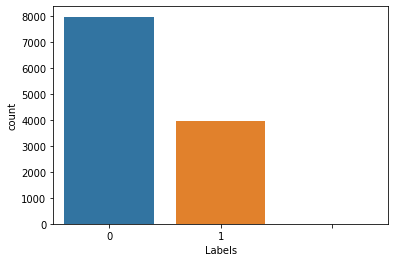

In [91]:
sns.countplot(x = 'Labels',data = train_off)
# 0 - not-offensive
# 1 - offensive

**Checking for missing values**

In [92]:
train_off.isna().sum() 

Text      0
Labels    0
dtype: int64

**WORD CLOUD**

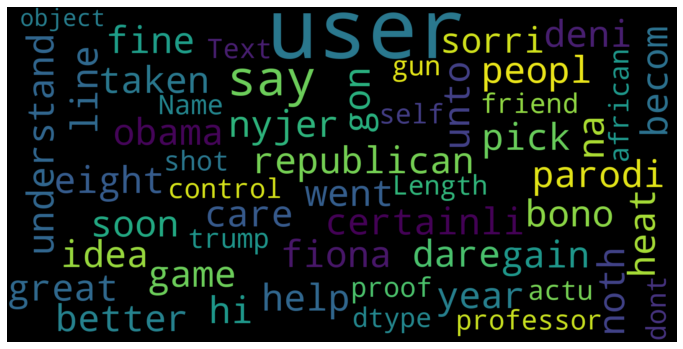

In [93]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(str(train_off['Text']))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Using CountVectorizer and TF-IDF Vectorizer for translating text data into numeric form acceptable by the model**

In [151]:
cv = CountVectorizer(stop_words='english',max_features=10000)
cv_train_features = cv.fit_transform(train_off['Text'])

In [152]:
tf1 = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,2),sublinear_tf=True)
tf_train_features = tf1.fit_transform(train_off['Text'])

In [153]:
cv = CountVectorizer(stop_words='english',max_features=10000)
cv_test_features = cv.fit_transform(test_off['Text'])

In [154]:
tf1 = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,2),sublinear_tf=True)
tf_test_features = tf1.fit_transform(test_off['Text'])

**SVM**

In [155]:
from sklearn import svm
from sklearn.metrics import accuracy_score

In [156]:
clf = svm.SVC()

In [157]:
X_train = tf1.transform(train_off["Text"])
y_train = train_off["Labels"]

In [158]:
X_test = tf1.transform(test_off["Text"])
y_test = test_off["Labels"]

In [159]:
clf1 = svm.SVC(C=10,gamma=0.1,kernel='rbf')

In [160]:
clf1.fit(X_train,y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [161]:
svm_preds = clf1.predict(X_test)

In [162]:
print("F1-score:",f1_score(svm_preds, y_test, average='macro'))
print("Accuracy:",accuracy_score(svm_preds,y_test))

F1-score: 0.47041095814765116
Accuracy: 0.8072009291521487


**FAST** **TEXT**

In [131]:
with open('fasttext_offensive_inputs.txt', 'w') as f:   #Converting data to a format accepted by fasttext and storing it in a text file
    for each_text, each_label in zip(train_off['Text'], train_off['Labels']):
        f.writelines(f'__label__{each_label} {each_text}\n')

In [132]:
fcl = fasttext.train_supervised('fasttext_offensive_inputs.txt', lr=0.01, wordNgrams=2, epoch=100)

In [133]:
predictions1 = fcl.predict(test_off['Text'].to_list())

In [134]:
def cleanpred_(text): # cleaning the predictions obtained by Fasttext 
  return text[0].replace("__label__","")

In [135]:
fast_preds = map(cleanpred_,predictions1[0])
fast_preds = list(fast_preds) # final predictions of fasttext model after cleaning

In [136]:
from sklearn.metrics import f1_score

In [137]:
print("F1-score:",f1_score(test_off['Labels'],fast_preds,average='macro'))
print("Accuracy:",accuracy_score(fast_preds,y_test))

F1-score: 0.4951632712418646
Accuracy: 0.8025551684088269


**ROBERTA-BASE**

In [117]:
!pip install transformers

In [118]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

In [120]:
task='offensive'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [121]:
labels = ['0','1']

In [122]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

In [138]:
sents = list(test_off['Text'][:])  # list of all texts

In [124]:
def get_preds(sentence):  # custom prediction function to extract the predicted labels
    text = sentence
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)  
    ranking = np.argsort(scores)
    ranking = ranking[::-1]

    dict1 = {}
    preds = []
    for i in range(scores.shape[0]):
        l = labels[ranking[i]]
        s = scores[ranking[i]]
        # print(f"{i+1}) {l} {np.round(float(s), 4)}")
        dict1[l] = s
        pred = max(dict1, key=dict1.get)
        preds.append(pred)

    prediction = list(set(preds))

    return prediction 

In [125]:
result = map(lambda x: get_preds(x), sents)
roberta_preds = list(result)
roberta_preds = [item for sublist in roberta_preds for item in sublist] #final list of predictions

In [126]:
print("F1:score",f1_score(test_off['Labels'],roberta_preds,average='macro'))
print("Accuracy:",accuracy_score(roberta_preds,test_off['Labels']))

F1:score 0.47041095814765116
Accuracy: 0.8072009291521487


**RANDOM FOREST**

In [127]:
rf = RandomForestClassifier(n_estimators=500)

In [128]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [129]:
rf_preds = rf.predict(X_test)

In [130]:
print("F1:score:",f1_score(rf_preds,y_test,average='macro'))
print("Accuracy:",accuracy_score(rf_preds,y_test))

F1:score: 0.4499093192654508
Accuracy: 0.7921022067363531
